In [1]:
import numpy as np
from numpy import random as rnd
import random
from matplotlib import pyplot as plt
import torch
import torch.nn

## First, tabular Q-learning
game from https://github.com/shakedzy/notebooks/blob/master/q_learning_and_dqn/Q%20Learning%20and%20Deep%20Q%20Network.ipynb

and structure inspired by Gaston Sivori, OIST

In [40]:
class Environment():
    board = None
    board_size = 0
    def __init__(self, board_size=4):
        self.board_size = board_size
        self.game_over = False
        self.terminal_state = np.ones(4).astype(int)
        self.reset()
    
    def reset(self): # new game
        self.state = np.zeros(self.board_size).astype(int) # [0,0,0,0]
        self.game_over = False
    
    def execute_action(self, action):
        # returns a tuple: (reward, game_over?)
        if self.state[action] == 0:
            self.state[action] = 1
            self.game_over = (len(np.where(self.state == 0)[0]) == 0)
            return 1
        else:
            return -1

class Agent():
    def __init__(self, board_size):
        self.Q = np.zeros((2,2,2,2,4)) # just make 4x1 games for now: 4 actions per 2^4 possible game states
        self.epsilon = .9
        self.gamma = 1
        self.lr = .1
        
    def select_action(self,state):
        if rnd.rand() < self.epsilon: # greedy action !kachow!
            return np.argmax(self.Q[tuple(state)])
        else:
            return random.choice(list(range(board_size)))
        
    def greedy_action(self,state):
        return np.argmax(self.Q[tuple(state)])
    
    def update(self,old_state,new_state,action,reward):
        q_old = self.Q[tuple(old_state) + (action,)] # Old Q value
        future_action = self.greedy_action(new_state) # Select next best action
        
        EV_new = self.Q[tuple(new_state) + (future_action,)] # What is reward for the best next action?
        
        if sum(new_state) == 4:
            EV_new = 0 # not a meaningful value
        
        rpe = self.lr * (reward + self.gamma * EV_new - q_old)
            
        self.Q[tuple(old_state) + (action,)] += rpe # update
        
class RLInterface():
    def __init__(self,agent,environment):
        self.agent = agent
        self.env = environment
        self.rewlist = []

    def step(self):
        old_state = env.state.copy()

        action = self.agent.select_action(old_state) # agent selects action
        rew = self.env.execute_action(action) # execute agent action into the environment
        new_state = env.state.copy()
        
        rpe = self.agent.update(old_state,new_state,action,rew) # update Q
        
        return rew
    
    def runTrials(self,nTrials):
        for i in range(nTrials):
            env.reset()
            total_rew = 0
            while not self.env.game_over:
                rew = self.step()
                total_rew += rew
            self.rewlist.append(total_rew)


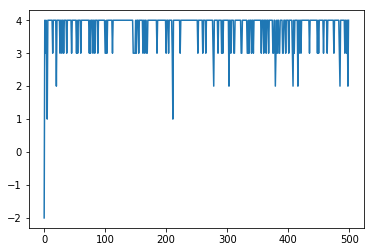

In [41]:
board_size = 4
agent = Agent(board_size)
env = Environment(board_size)
rl = RLInterface(agent,env)

rl.runTrials(500)

plt.plot(rl.rewlist)

In [4]:
print(np.all(rl.env.state == rl.env.terminal_state))

True


## Now, using a DQN

In [5]:
import torch
import torch.nn as nn
import torch.autograd as autograd
import torch.nn.functional as F

In [28]:
GAMMA = 0.999
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 200
TARGET_UPDATE = 10

# just a feed forward neural network to estimate Q(s,a) values
class DQN(nn.Module):
    def __init__(self, envstate_dim, action_dim):
        super(DQN, self).__init__()
        self.input_dim = envstate_dim
        self.output_dim = action_dim
        
        self.ff = nn.Sequential(
            nn.Linear(self.input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 124),
            nn.ReLU(),
            nn.Linear(124, 64),
            nn.ReLU(),
            nn.Linear(64, self.output_dim),
#             nn.Softmax(dim=0)
        )

    def forward(self, state):
        qvals = self.ff(state)
        return qvals

# replay buffers implemented as lists
class Buffer():
    def __init__(self):
        self.buffer = []
        
    def size(self):
        return len(self.buffer)
        
    def push(self,state,action,new_state,reward):
        experience = (state,action,new_state,reward)
        self.buffer.append(experience)
    
    def sample(self,batch_size):
        batchSample = random.sample(self.buffer,batch_size)
        # now need to put everyone in the correct columns
        state_batch = []
        action_batch = []
        new_state_batch = []
        reward_batch = []
        
        # prepare the batch sample for training
        for experience in batchSample:
            state,action,new_state,reward = experience
            state_batch.append(state)
            action_batch.append(action)
            new_state_batch.append(new_state)
            reward_batch.append(reward)
        return (state_batch, action_batch, reward_batch, new_state_batch)
    
# a class for agents that use feedforward neural networks to calculate Q(s,a)
class DeepAgent():
    def __init__(self, board_size):
        self.policy_net = DQN(board_size,board_size) # network used to calculate policy
        self.target_net = DQN(board_size,board_size) # network used to calculate target
        self.target_net.eval() # throw that baby in eval mode because we don't care about its gradients
        self.target_update = 50 # 
        self.replay_buffer = Buffer() # replay buffer implemented as a list
        self.eps_start = 0.1 # exploration rate
        self.eps_end = 0.95
        self.eps_decay = 300
        self.epsilon = self.eps_start
        self.gamma = 0.99 # discount
        
        self.optimizer = torch.optim.SGD(self.policy_net.parameters(),lr=0.01, momentum=0.9)
#         self.optimizer = torch.optim.RMSprop(self.policy_net.parameters())
#         self.optimizer = torch.optim.Adam(self.policy_net.parameters())
        self.huber_loss = F.smooth_l1_loss
        
    def select_action(self,state):
        state = torch.FloatTensor(state).float()
        if rnd.rand() < self.epsilon: # greedy action
            with torch.no_grad():
                qvals = self.policy_net.forward(state) # forward run through the policy network
                action = np.argmax(qvals.detach().numpy()) # need to detach from auto_grad before sending to numpy
        else:
            action = random.choice(list(range(board_size)))
        return action
    
    def update(self, batch_size):
        if self.replay_buffer.size() < batch_size:
            return
        batch = self.replay_buffer.sample(batch_size)
        
        self.optimizer.zero_grad() # zero_grad before computing loss
        
        loss = self.compute_loss(batch)

        loss.backward() # perform back propagation
        
        for param in self.policy_net.parameters():
            param.grad.data.clamp_(-1, 1)
            
        self.optimizer.step()
        
        return loss
        
    def compute_loss(self, batch):
        states, actions, rewards, next_states = batch
        states = torch.FloatTensor(states)
        actions = torch.LongTensor(actions)
        rewards = torch.FloatTensor(rewards)
        next_states = torch.FloatTensor(next_states)

        curr_Q = self.policy_net.forward(states).gather(1,actions.unsqueeze(1)) # calculate the current Q(s,a) estimates
        next_Q = self.target_net.forward(next_states) # calculate Q'(s,a) (EV)
        max_next_Q = torch.max(next_Q,1)[0] # equivalent of taking a greedy action
        expected_Q = rewards + self.gamma * max_next_Q # Calculate total Q(s,a)
        
#         print(curr_Q.size())
#         print(expected_Q.size())
        loss = self.huber_loss(curr_Q, expected_Q.unsqueeze(1))
        return loss
    
class DeepRLInterface():
    def __init__(self,agent,environment):
        self.agent = agent
        self.env = environment
        self.rewlist = []
        self.batch_size = 50

    def step(self):
        state = env.state.copy()
        
        action = self.agent.select_action(state) # agent selects action
        rew = self.env.execute_action(action) # execute agent action into the environment
        new_state = env.state.copy() 
        if not np.all(rl.env.state == rl.env.terminal_state):
            self.agent.replay_buffer.push(state,action,new_state,rew)
        
        loss = self.agent.update(self.batch_size)
        self.losslist.append(loss)
        return state,action,rew,new_state
    
    def runTrials(self,nTrials):
        counter = 0 # for batch training
        self.clist = []
        self.rewlist = []
        self.losslist = []
        self.eps = []
        for i in range(nTrials):
            env.reset()
            total_rew = 0
            tstates,tactions,trews,tnewstates = [] , [] , [] , [] # accumulate states to debug
            while not self.env.game_over: # while the game is not over, keep taking actions
                state,action,rew,new_state = self.step()
                total_rew += rew
                
                tstates.append(state)
                tactions.append(action)
                trews.append(rew)
                tnewstates.append(tnewstates)
                counter += 1
                
#             we seem to be getting stuck making the same bad action
#             if total_rew < 0:
#                 print('States:',tstates)
#                 print('Actions:',tactions)
#                 print('Rewards:',trews)
#                 print('newStates:',tnewstates)
            self.rewlist.append(total_rew)
    
            if counter % self.agent.target_update == 0: # update the target network
                self.agent.target_net.load_state_dict(self.agent.policy_net.state_dict())
            # update agent epsilon
            self.agent.epsilon = (self.agent.eps_end + (self.agent.eps_start - self.agent.eps_end) * 
                                                        np.exp(-1. * counter / self.agent.eps_decay))
            self.eps.append(self.agent.epsilon)
            

In [34]:
board_size = 4
agent = DeepAgent(board_size)
env = Environment(board_size)
rl = DeepRLInterface(agent,env)

rl.runTrials(500)


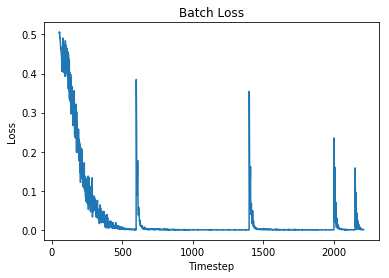

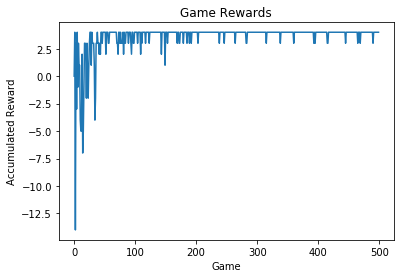

In [35]:
plt.title('Batch Loss')
plt.plot(rl.losslist)
plt.xlabel('Timestep')
plt.ylabel('Loss')
plt.figure()
plt.title('Game Rewards')
plt.xlabel('Game')
plt.ylabel('Accumulated Reward')
plt.plot(rl.rewlist)


In [36]:
# Q values check out
for state in [[0,1,1,1] ,[1,0,1,1],[1,1,0,1],[1,1,1,0],[0,0,1,1],[0,1,0,1],[1,0,0,1],[0,0,0,0],[0,0,0,1],[0,0,1,0],
              [0,1,0,0]]:
    q = list(rl.agent.policy_net(torch.FloatTensor(state)).detach().numpy())
    argmax = np.argmax(list(rl.agent.policy_net(torch.FloatTensor(state)).detach().numpy()))
    print("Q values for state ",state,": ",q,"-> action",argmax)


Q values for state  [0, 1, 1, 1] :  [3.1401424, 1.7045406, 1.6679184, 1.6673598] -> action 0
Q values for state  [1, 0, 1, 1] :  [1.627376, 3.1256948, 1.6335013, 1.629583] -> action 1
Q values for state  [1, 1, 0, 1] :  [1.5684097, 1.6609493, 3.033236, 1.5845115] -> action 2
Q values for state  [1, 1, 1, 0] :  [1.5954088, 1.5848771, 1.5722404, 3.062582] -> action 3
Q values for state  [0, 0, 1, 1] :  [3.6364446, 3.677867, 2.1714516, 2.1604738] -> action 1
Q values for state  [0, 1, 0, 1] :  [3.6954966, 2.1600657, 3.7044158, 2.2241704] -> action 2
Q values for state  [1, 0, 0, 1] :  [2.1725368, 3.612753, 3.6476483, 2.3108978] -> action 2
Q values for state  [0, 0, 0, 0] :  [4.5795426, 4.4408746, 4.5556192, 4.616192] -> action 3
Q values for state  [0, 0, 0, 1] :  [4.149605, 4.0902715, 4.137716, 2.6238265] -> action 0
Q values for state  [0, 0, 1, 0] :  [4.140303, 4.129592, 2.5354776, 4.2231035] -> action 3
Q values for state  [0, 1, 0, 0] :  [4.0789065, 2.5970469, 4.108357, 4.0659423] -